<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Things-to-Consider" data-toc-modified-id="Things-to-Consider-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Things to Consider</a></span></li></ul></div>

## Things to Consider

1. Removing the activation function
2. Different activation functions
3. Different numbers of hidden layers
4. Different numbers of neurons per layer
5. Comparing depth vs height with respect to loss vs epoch

- with and without bias?
- shift input away from 0 (linspace(3, 9))

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

from fastprogress.fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

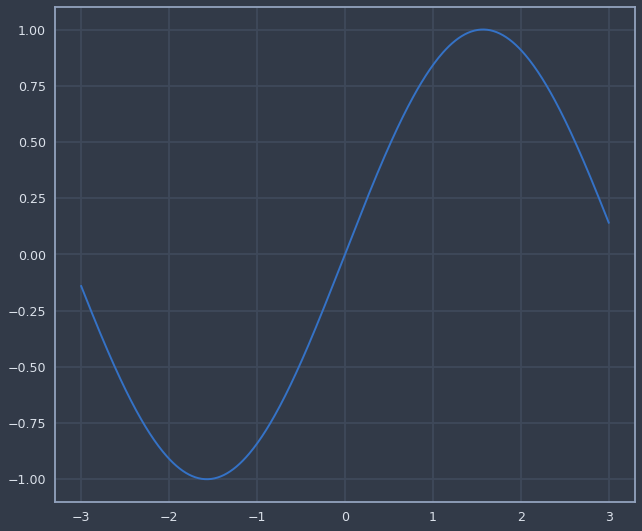

In [63]:
N = 500
X = torch.linspace(-3, 3, N).reshape(-1, 1)
y = torch.sin(X)
_ = plt.plot(X, y)

In [64]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()

        # Hidden layers
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # Output layer
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

In [65]:
# Height vs depth
layer_sizes = (1, 8, 1)
model = NeuralNetwork(layer_sizes)
optimizer = torch.optim.Adam(model.parameters())

summary(model)

criterion = nn.MSELoss()

num_epochs = 2000

# Put into function?
losses = []
for epoch in progress_bar(range(num_epochs)):
    yhat = model(X)
    loss = criterion(yhat, y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Final loss: {losses[-1]:.3f}")

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  16
|    |    └─ReLU: 3-2                    --
|    └─Linear: 2-2                       9
Total params: 25
Trainable params: 25
Non-trainable params: 0


Final loss: 0.000


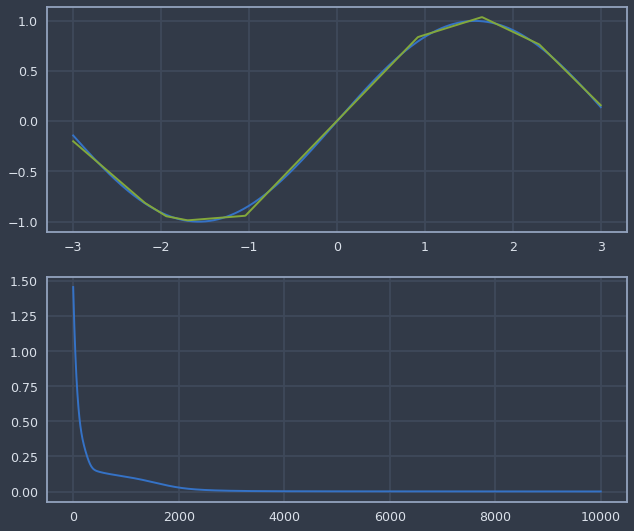

In [66]:
_, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(X, y)
ax1.plot(X, yhat.detach())
_ = ax2.plot(losses)

In [67]:
final_layer_input = None

def capture_final_outputs(module, layer_in, layer_out) -> None:
    global final_layer_input
    final_layer_input = layer_in[0].detach()

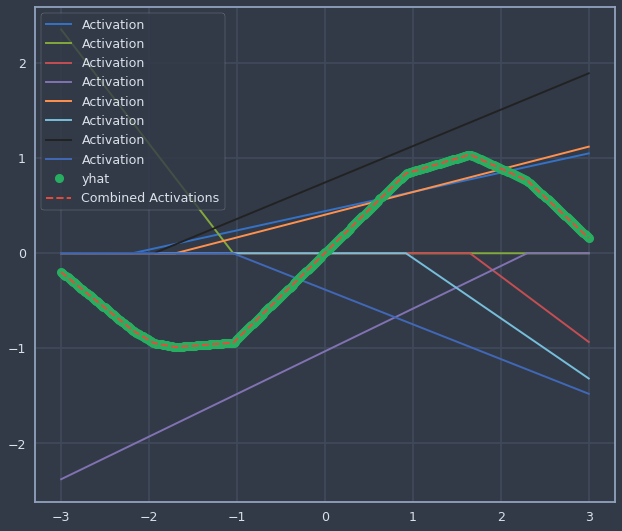

In [68]:
# Register hook to capture input to final layer (if not already registered)
if final_layer_input == None:
    final_layer = model.layers[-1]
    final_layer.register_forward_hook(capture_final_outputs)

# X = torch.linspace(10, 20, 100).reshape(-1, 1)
# Compute model output and capture input to final layer
yhat = model(X)

# Grab parameters for the output layer
WL = list(model.parameters())[-2].detach()
bL = list(model.parameters())[-1].item()

# Plot each input to the final layer
plt.plot(X, final_layer_input * WL, label="Activation")

# Plot the output of the final layer
plt.plot(X, yhat.detach(), "o", label="yhat")

# Compare with hand-computed final layer output
plt.plot(X, final_layer_input @ WL.T + bL, "--", label="Combined Activations")

_ = plt.legend()

In [69]:
def init_weights(layer):
    if type(layer) == torch.nn.Linear:
        print("Initializing", layer)
        
        if kind == "zeros":
            layer.weight.data.fill_(0.0)
            layer.bias.data.fill_(0.0)
        
        elif kind == "ones":
            layer.weight.data.fill_(1.0)
            layer.bias.data.fill_(1.0)

        elif kind == "uniform":
            layer.weight.data.uniform_()
            layer.bias.data.fill_(0.0)
        
        elif kind == "normal":        
            layer.weight.data.normal_()
            layer.bias.data.fill_(0.0)

        elif kind == "normal2":        
            layer.weight.data.normal_() * (1 / torch.sqrt(layer.weight.shape[0]))
            layer.bias.data.fill_(0.0)
        
        elif kind == "xavier":
            torch.nn.init.xavier_uniform_(layer.weight)
        
        elif kind == "kaiming":
            torch.nn.init.kaiming_normal_(layer.weight)
        
        else:
            print(f"'{kind}' is not handled")


kind = "kaiming"
model.apply(init_weights)

with torch.no_grad():
    A = X
    std, mean = torch.std_mean(A)
    print(f"*** Mean = {mean.item():.3f}, STD = {std.item():.3f}")
    for layer in model.layers:
        print(layer)
        A = layer(A)
        std, mean = torch.std_mean(A)
        print(f"*** Mean = {mean.item():.3f}, STD = {std.item():.3f}")

Initializing Linear(in_features=1, out_features=8, bias=True)
Initializing Linear(in_features=8, out_features=1, bias=True)
*** Mean = 0.000, STD = 1.737
Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): ReLU()
)
*** Mean = 1.200, STD = 1.721
Linear(in_features=8, out_features=1, bias=True)
*** Mean = -1.526, STD = 1.108
